#### Extract patches from data_processedv0 and make data_processedv1 with subfolder named images and masks folder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "data_processedv0", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "dataset", "data_processedv0", "masks/")



# Make new folders

IMAGES_DEST_v1 =  os.path.join(ROOT_DIR, "dataset", "data_processedv1", "images/")
MASKS_DEST_v1 = os.path.join(ROOT_DIR, "dataset", "data_processedv1", "masks/")

print(IMAGES_DEST_v1)
print(MASKS_DEST_v1)

# Create folders
create_directory(IMAGES_DEST_v1)
create_directory(MASKS_DEST_v1)

/home/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv1/images/
/home/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv1/masks/


In [2]:
#try:
#  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass

In [3]:
def pad(im, desired_size = 900):
    
    """
    Pad input image.
    Args:
        im (np.array): Input image numpy array
    Returns:
        new_im: Padded image array
    """
    
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im


def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    

Index:  119
(877, 802, 3) (877, 802)
Ground truth classes:  [0 1 2]


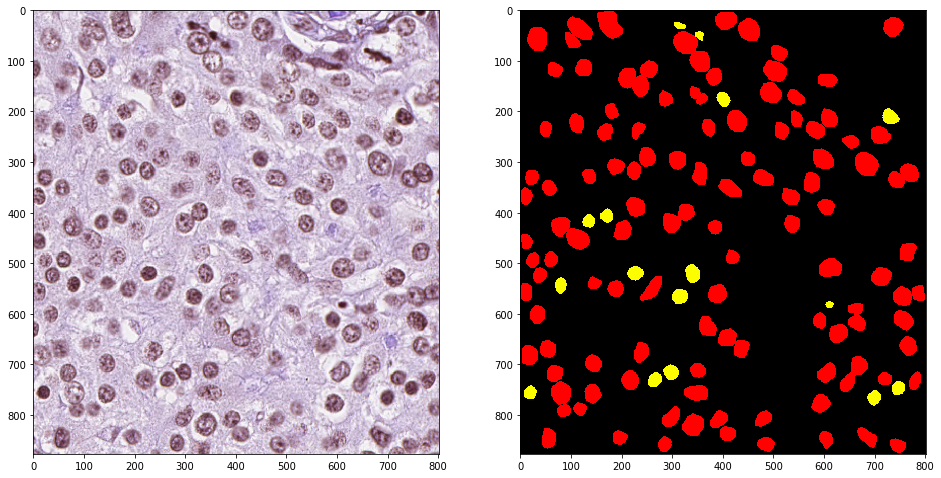

In [4]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 154 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [5]:
def extract_patches(whole_slide, patch_size, max_patch):
    """
    Get patches
    
    https://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html
    https://github.com/scikit-learn/scikit-learn/issues/10910
    """
    
    from sklearn.feature_extraction import image
    patches = image.extract_patches_2d(whole_slide, patch_size, max_patches=max_patch, random_state=42)
    return patches

In [6]:
# For testing extract patch function

#from sklearn.datasets import load_sample_image
# Use the array data from the first image in this dataset:
#one_image = load_sample_image("china.jpg")
#print('Image shape: {}'.format(one_image.shape))
#plt.imshow(one_image)
#patches = None
#patches = extract_patches(one_image, (128, 128), 100)
#print('Patches shape: {}'.format(patches.shape))

In [7]:
image.shape, gt.shape

((877, 802, 3), (877, 802))

#### Extract patches from a single image and mask

In [8]:
img_patches = None
gt_patches = None

patch_size = (84, 84)
max_patch = 50

img_patches = extract_patches(image, patch_size, max_patch)
gt_patches = extract_patches(gt, patch_size, max_patch)

print('Patches shape: {}, {}'.format(img_patches.shape, gt_patches.shape))

Patches shape: (50, 84, 84, 3), (50, 84, 84)


In [9]:
#def process(image, mask):
#    f, axarr = plt.subplots(1,2, figsize=(16, 16))
#    axarr[0].imshow(image, cmap=map_name, norm=norm)
#    axarr[1].imshow(mask, cmap=map_name, norm=norm)
    
#for img, msk in zip(img_patches[:100], gt_patches[:100]):
#    process(img, msk)

#### Extract patches and save

In [10]:
patch_size = (64, 64)
max_patch = 100

# Iterate over all image and masks
ct=0

for img_path, gt_path in tqdm(zip(image_fns[:], gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, img_path))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, patch_size, max_patch)
    gt_patches = extract_patches(gt, patch_size, max_patch)

    for im, msk in zip(img_patches, gt_patches):
        # Save image patch 
        save_nuclei(IMAGES_DEST_v1 + "{}.png".format(ct), im)
        # Save mask patch
        save_nuclei(MASKS_DEST_v1 + "{}.png".format(ct), msk)
        ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

209it [00:46,  4.46it/s]


### Check image-mask order

In [11]:
image_fns = sorted(next(os.walk(IMAGES_DEST_v1))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST_v1))[2])

image_fns[:5], gt_fns[:5]

(['0.png', '1.png', '10.png', '100.png', '1000.png'],
 ['0.png', '1.png', '10.png', '100.png', '1000.png'])

In [12]:
# Check if images and gt match in data_processedv0
fc = 0
for x,y in tqdm(zip(image_fns, gt_fns)):
    image = skimage.io.imread(os.path.join(IMAGES_DEST_v1, x))
    gt = skimage.io.imread(os.path.join(MASKS_DEST_v1, y))
    #print(image.shape[:2], gt.shape)
    
    if image.shape[:2] == gt.shape:
        #print(True)
        pass
    else:
        fc+=1
        print(False)
        
print("False count :", fc)

20900it [00:13, 1530.53it/s]

False count : 0


### Display some image-masks

Index:  15983
Index:  12457
Index:  18051
Index:  11016
Index:  17721
Index:  9233
Index:  11174
Index:  2890
Index:  4512
Index:  15789
Index:  11443
Index:  3570
Index:  7194
Index:  14218
Index:  12671
Index:  19669
Index:  19386
Index:  20628
Index:  17838
Index:  9733
Index:  10697
Index:  5031
Index:  13470
Index:  20094
Index:  8548
Index:  12305
Index:  19058
Index:  12987
Index:  15275
Index:  18399
Index:  7467
Index:  10209
Index:  6428
Index:  9044
Index:  13215
Index:  997
Index:  20840
Index:  15752
Index:  13692
Index:  6487
Index:  15865
Index:  5912
Index:  16746
Index:  8314
Index:  5240
Index:  7901
Index:  8905
Index:  4183
Index:  11610
Index:  8912


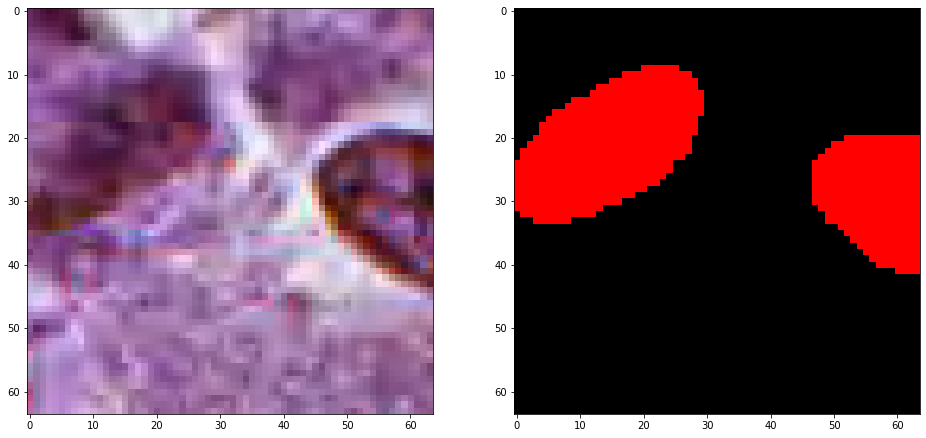

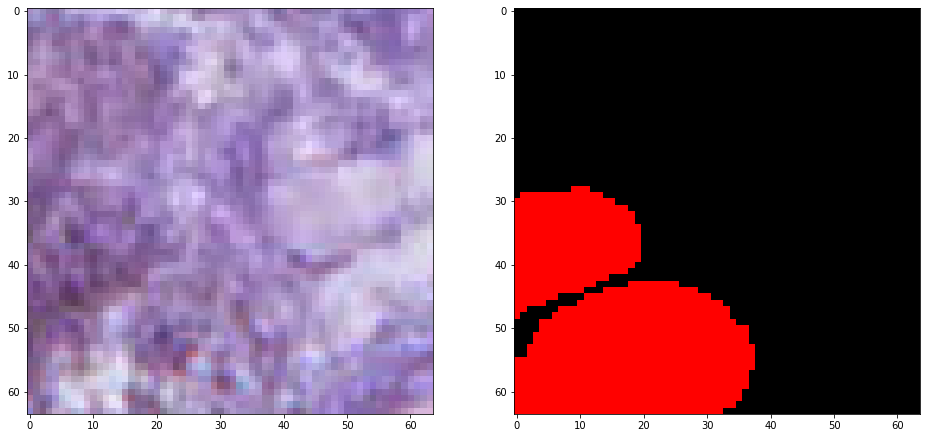

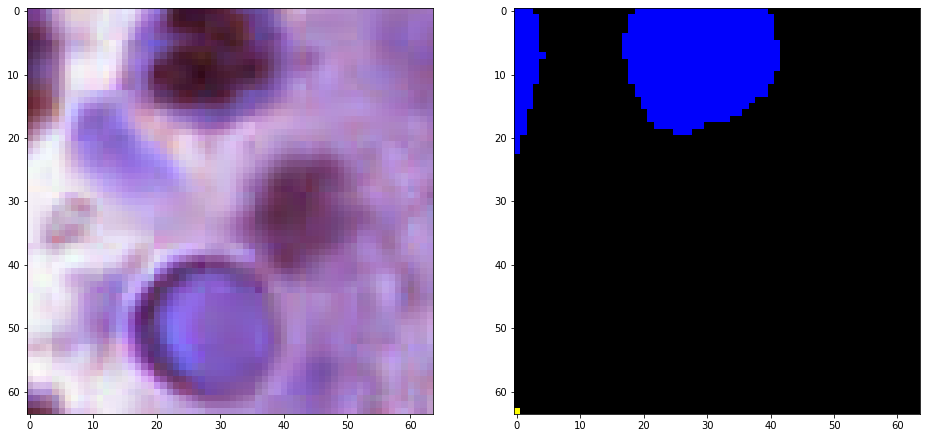

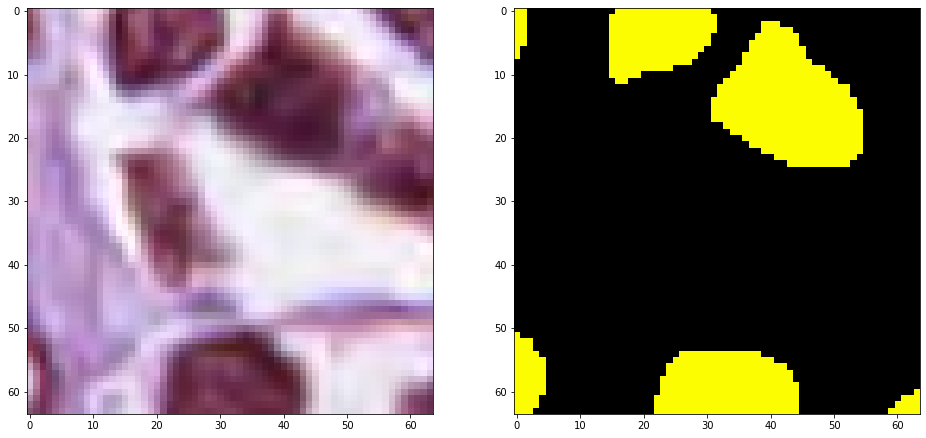

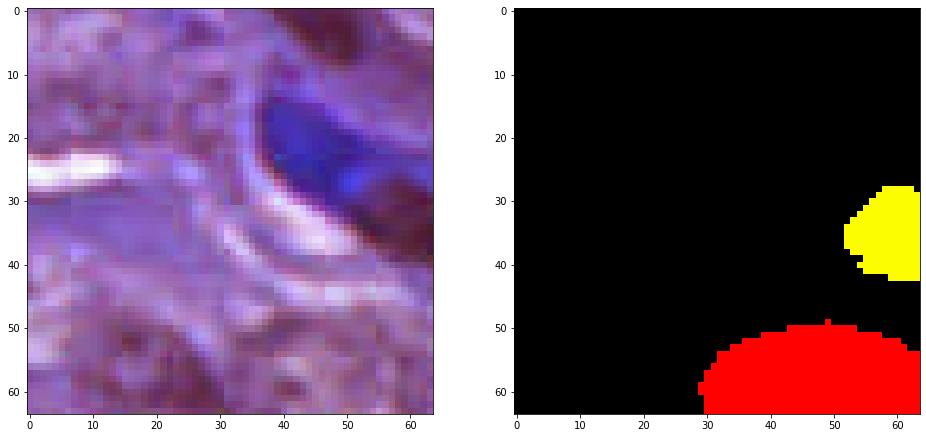

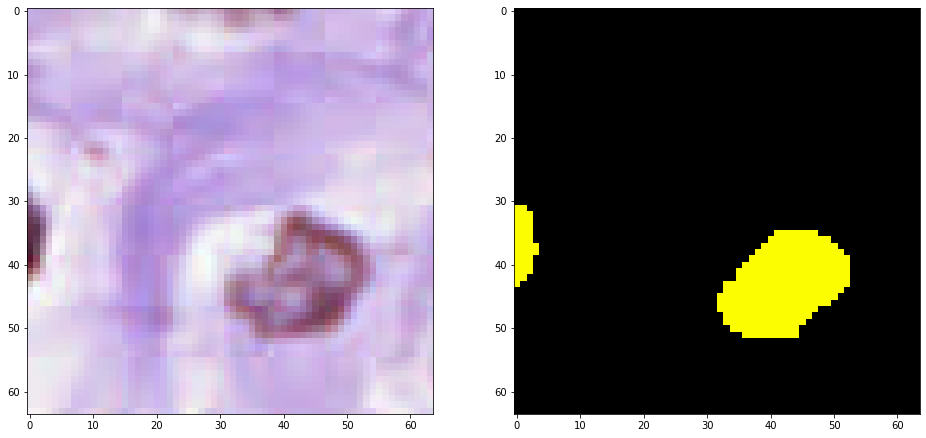

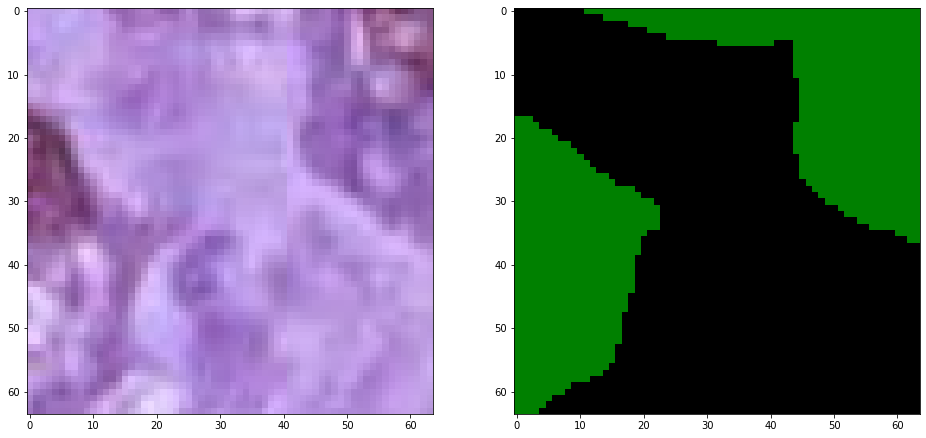

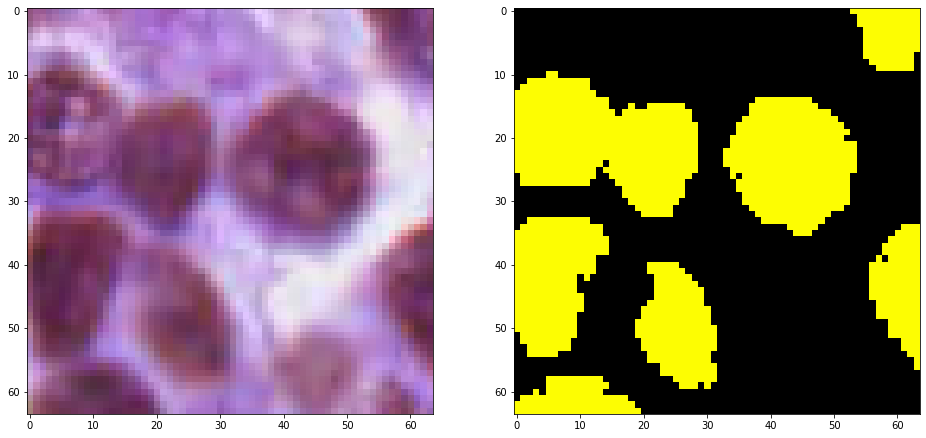

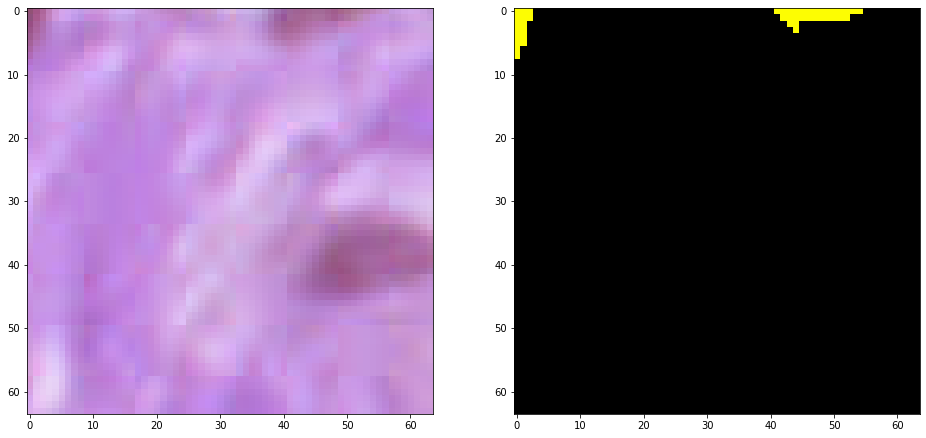

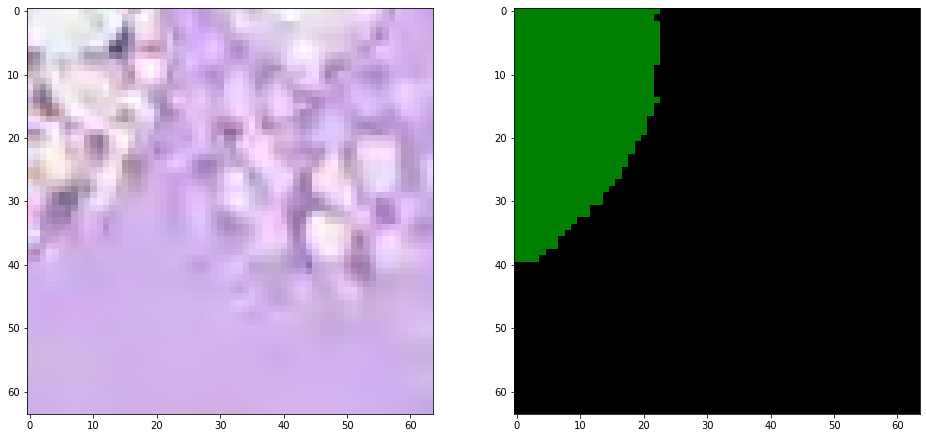

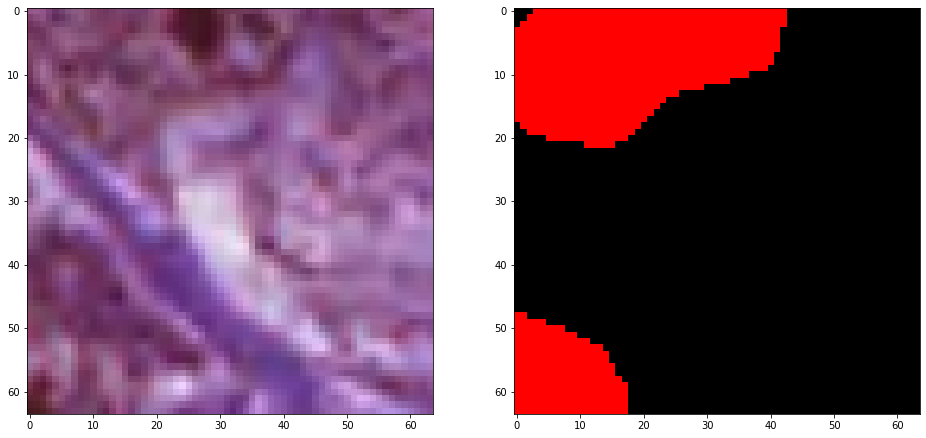

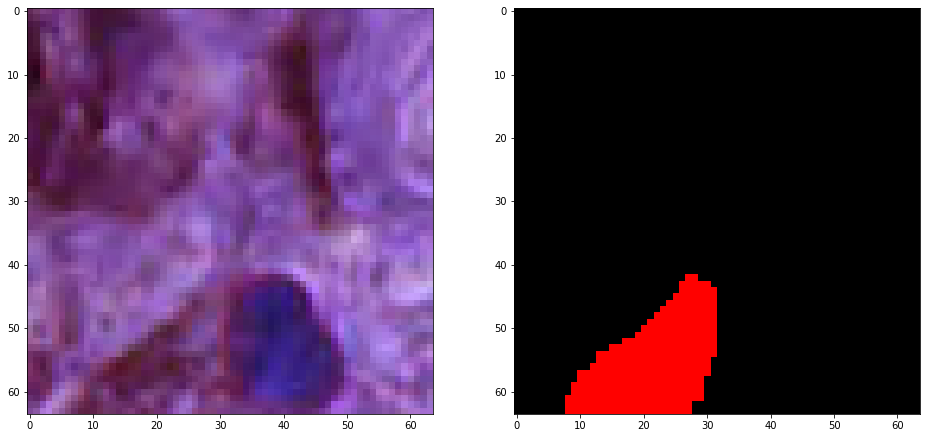

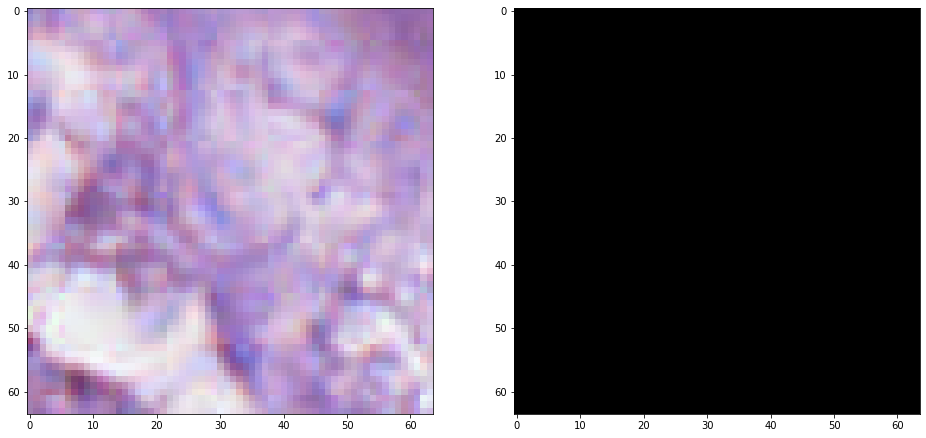

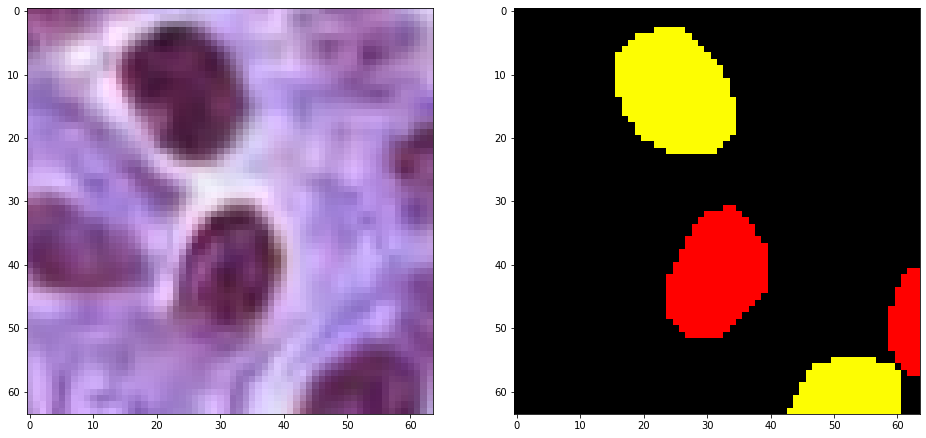

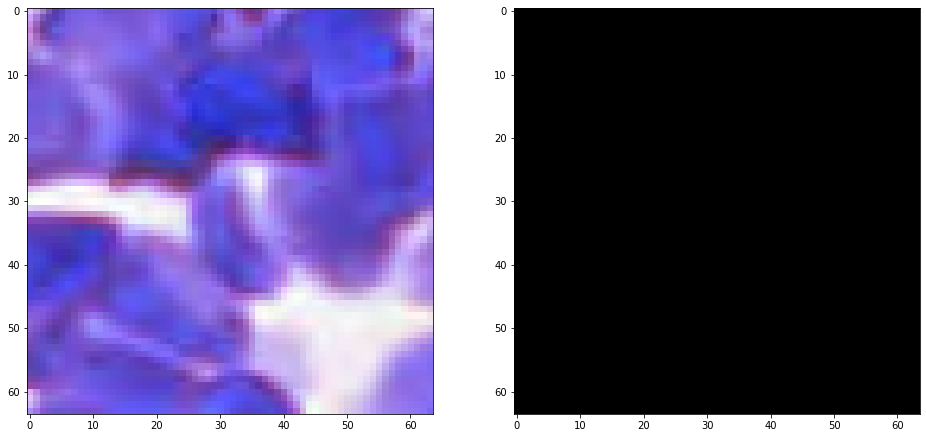

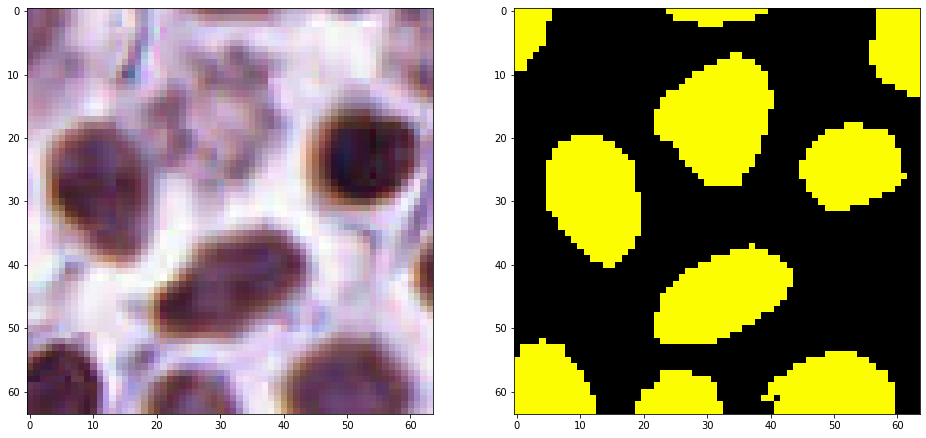

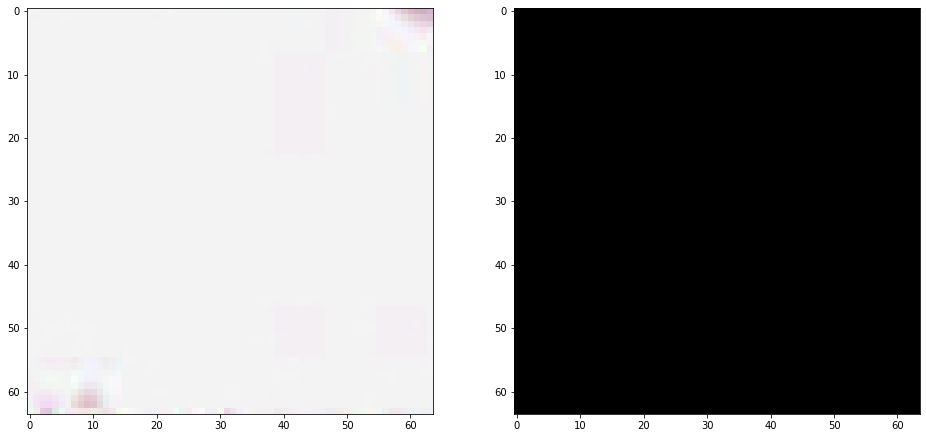

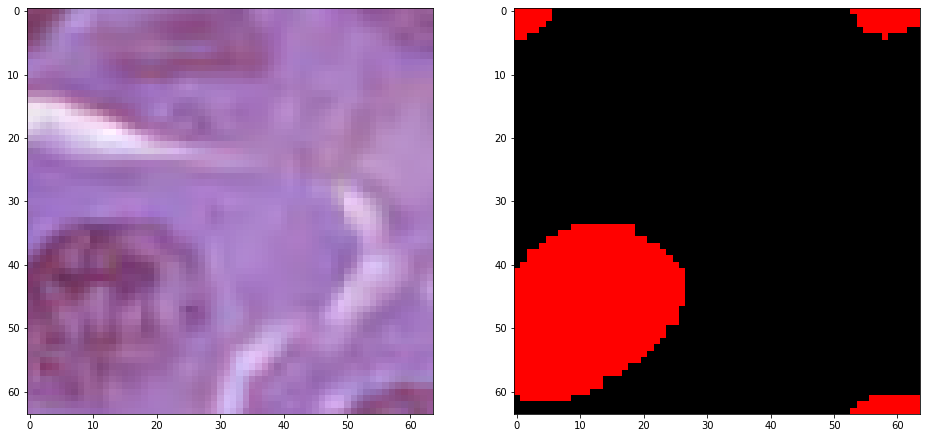

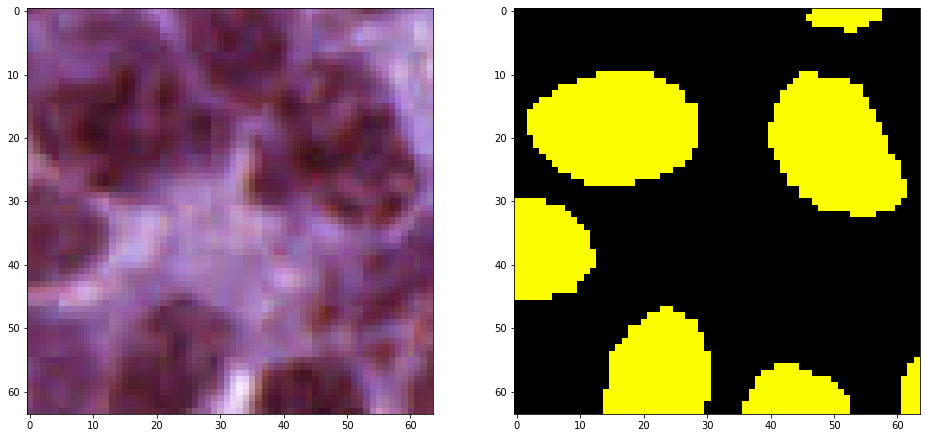

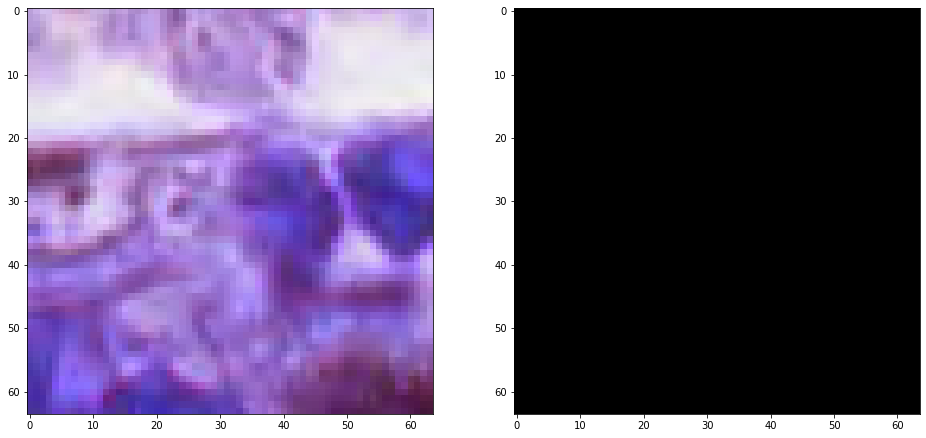

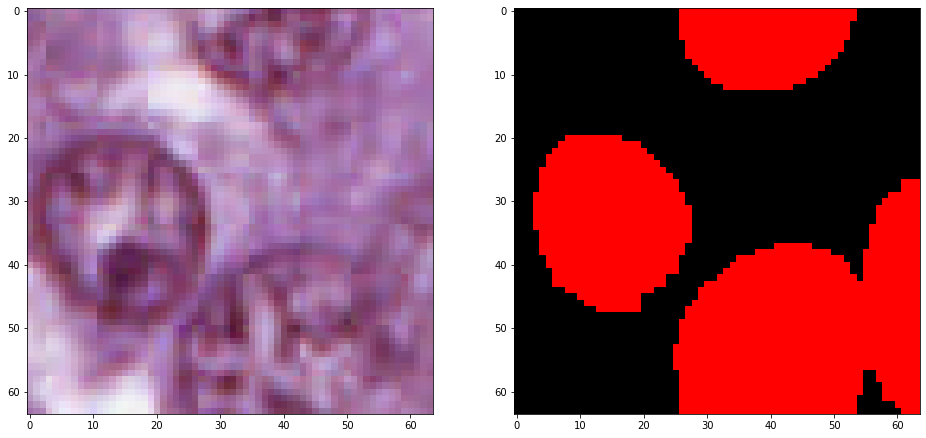

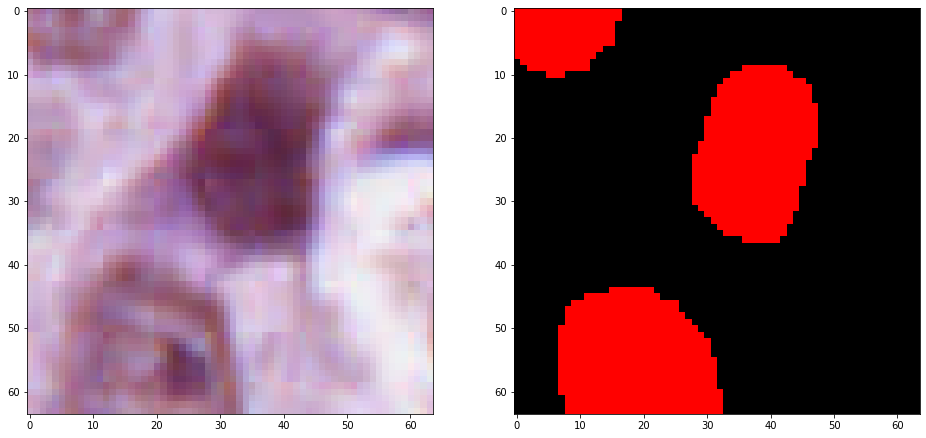

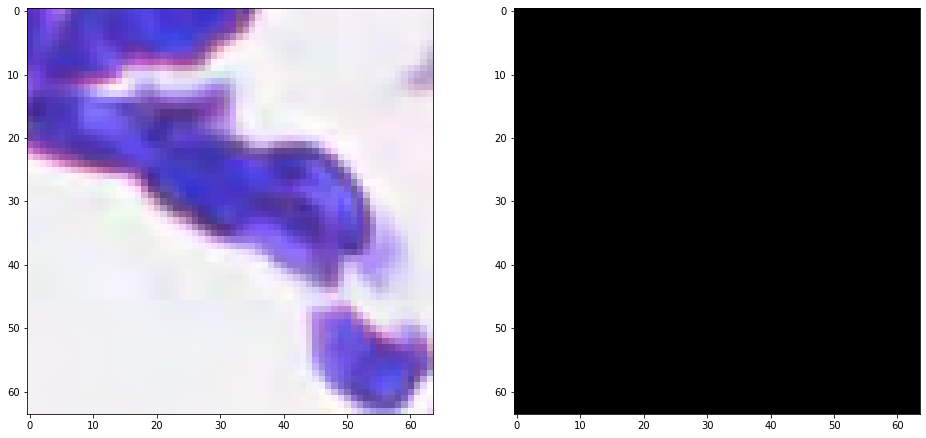

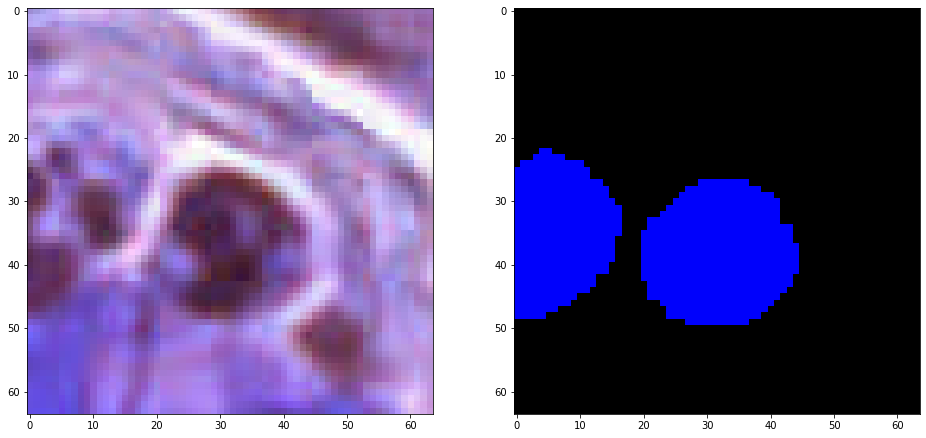

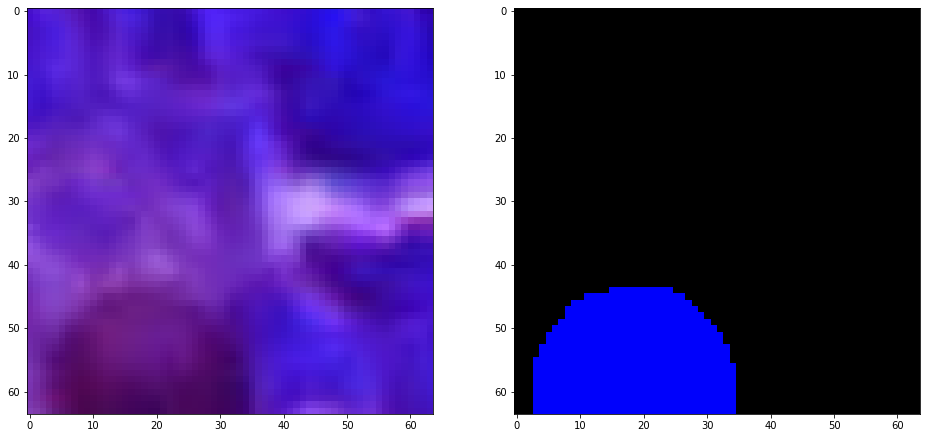

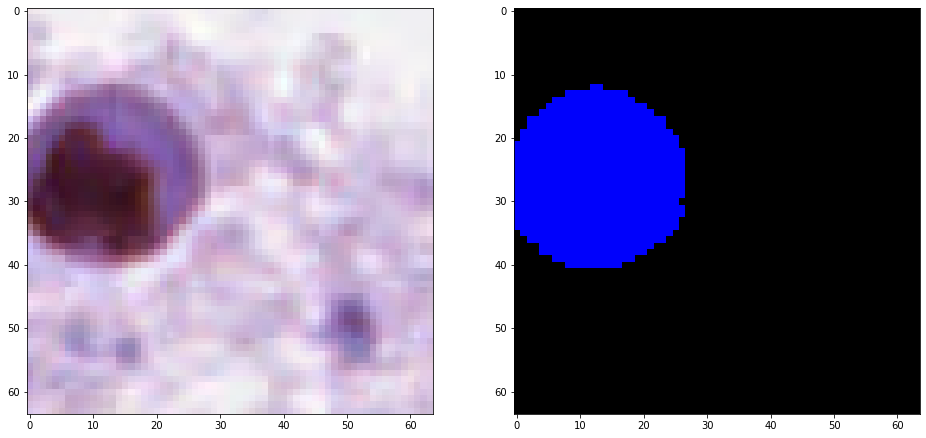

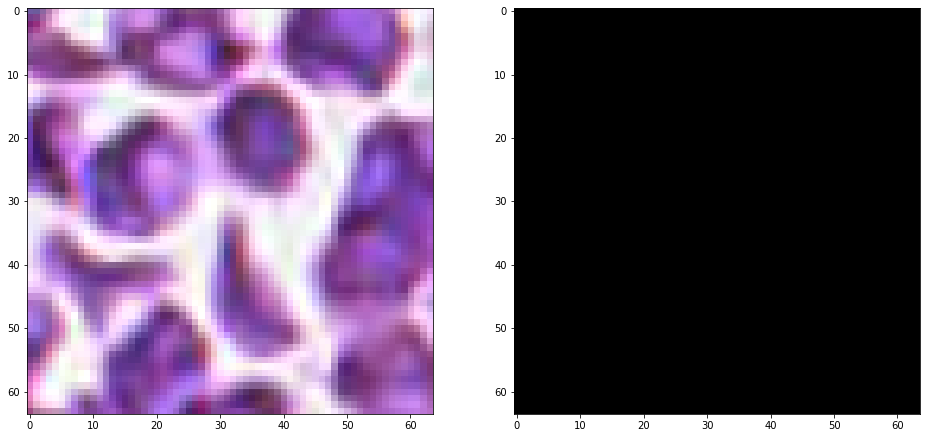

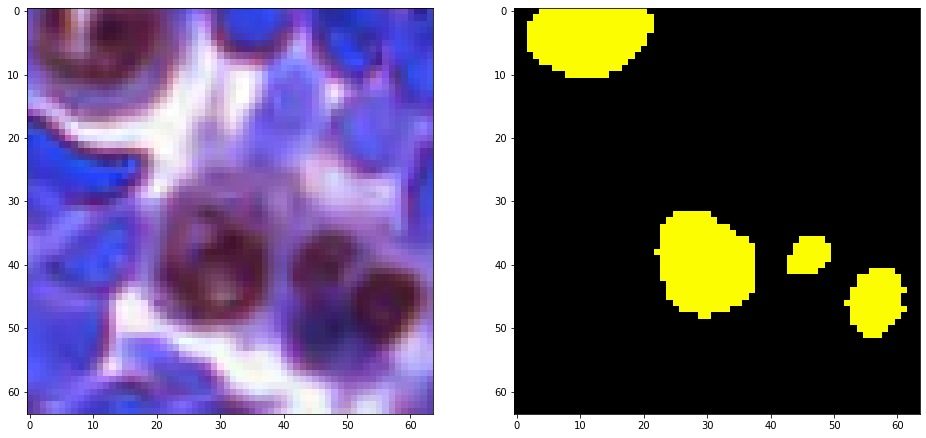

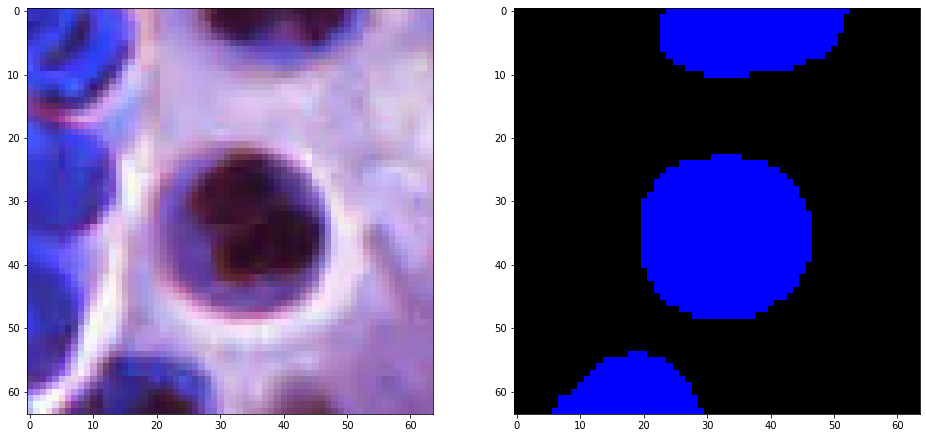

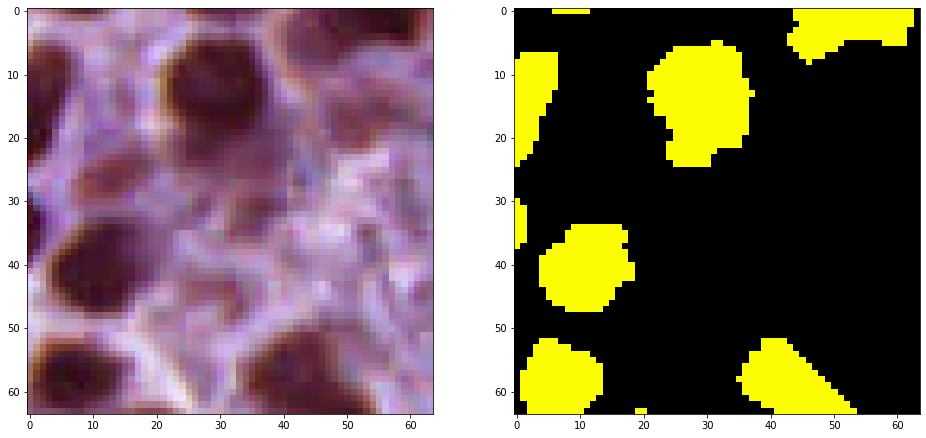

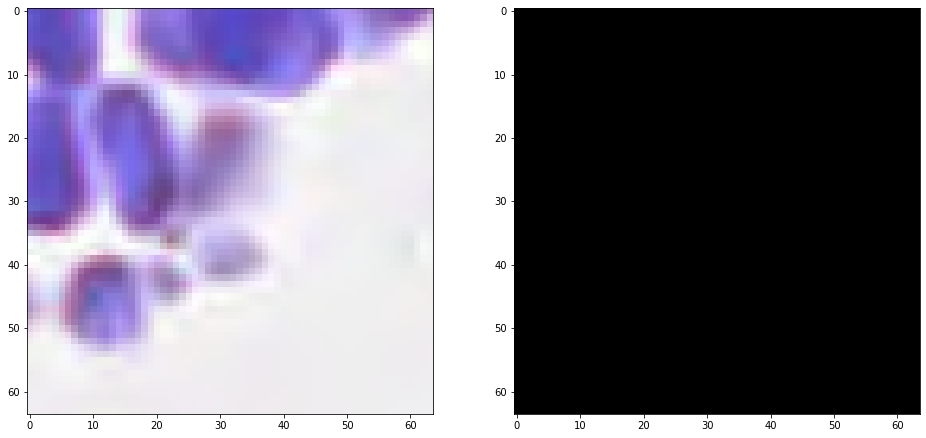

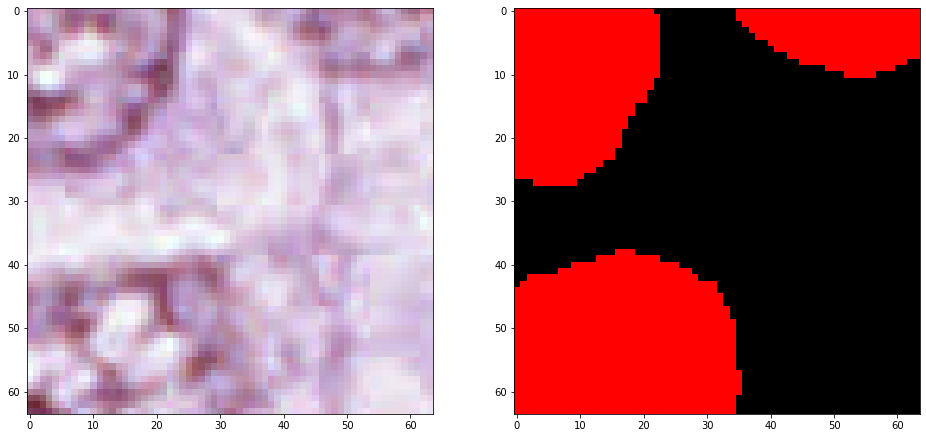

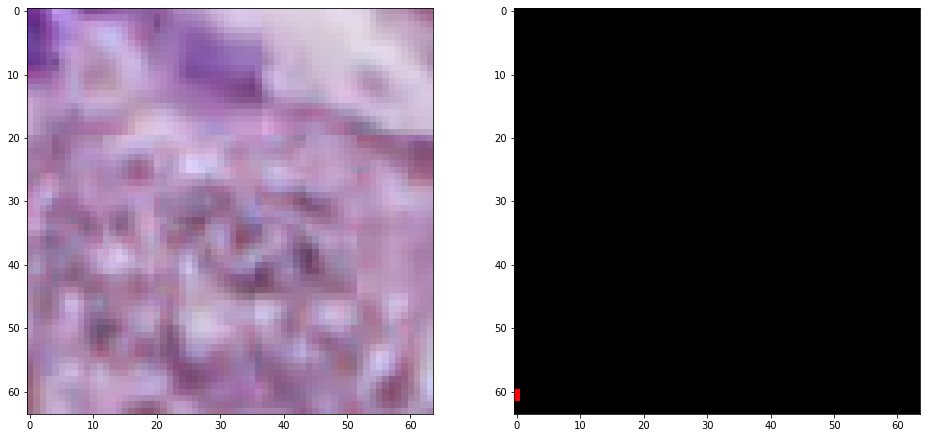

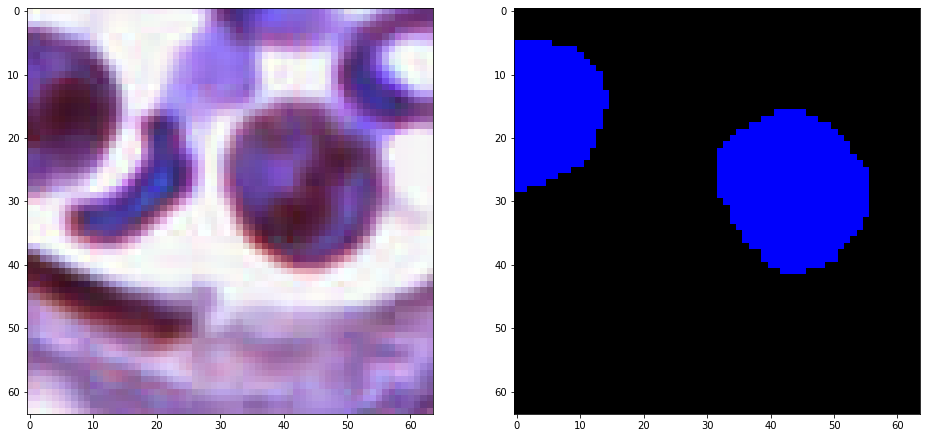

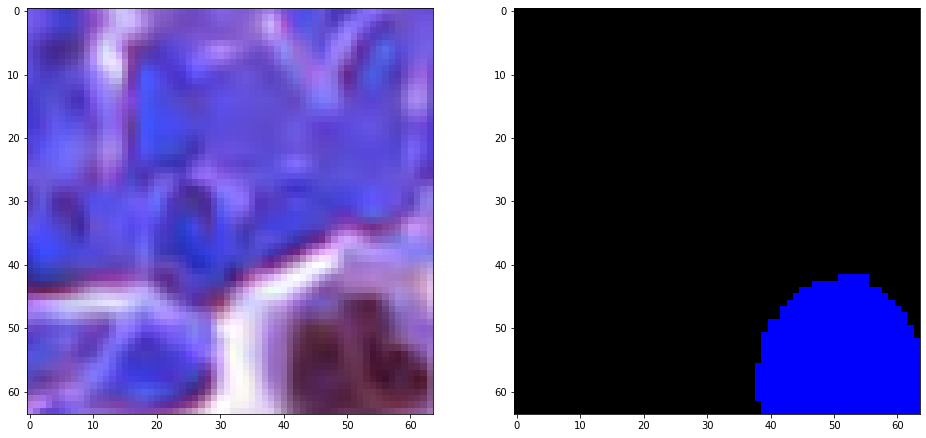

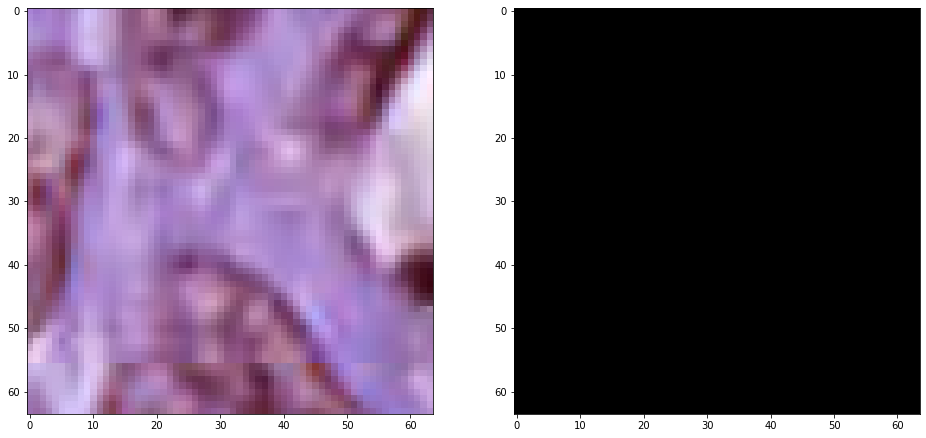

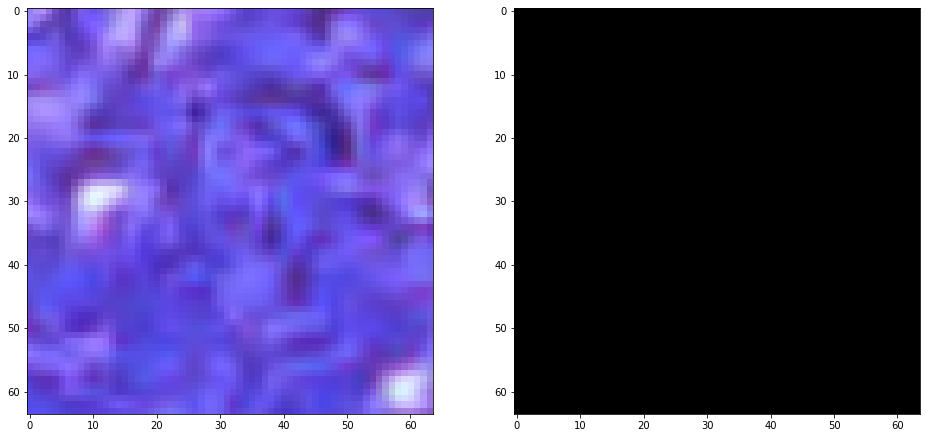

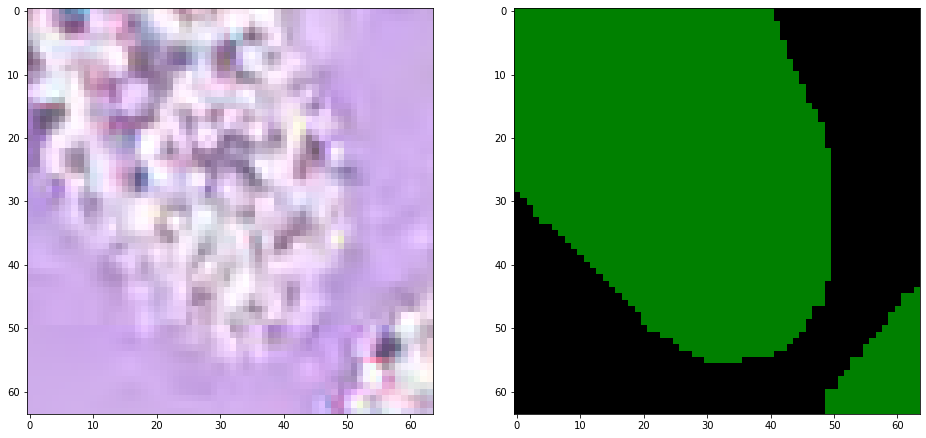

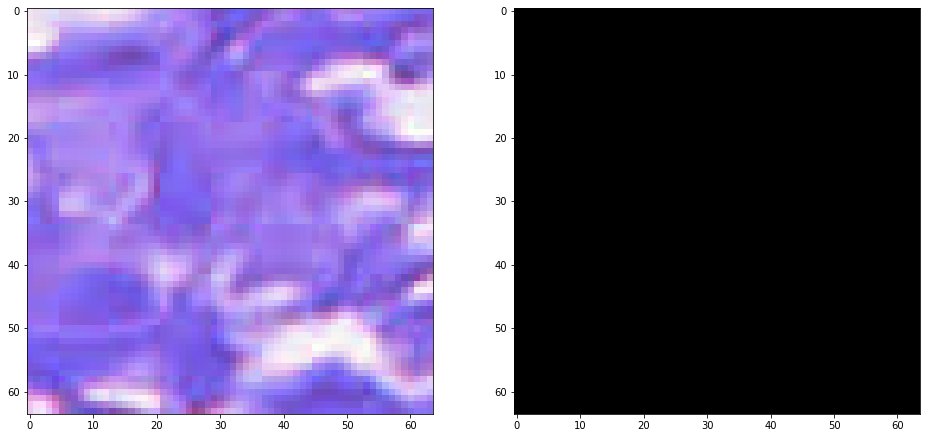

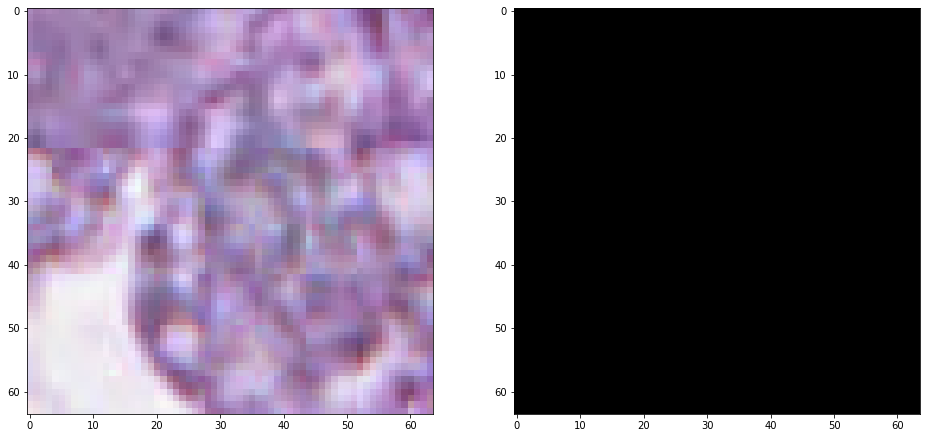

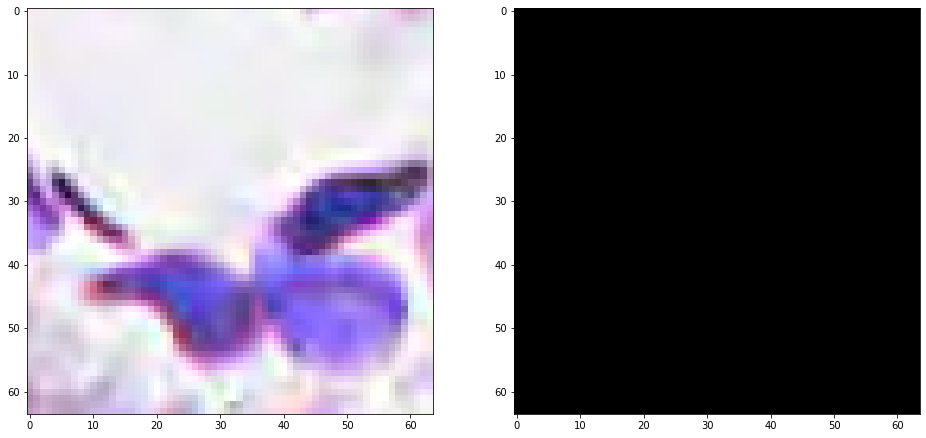

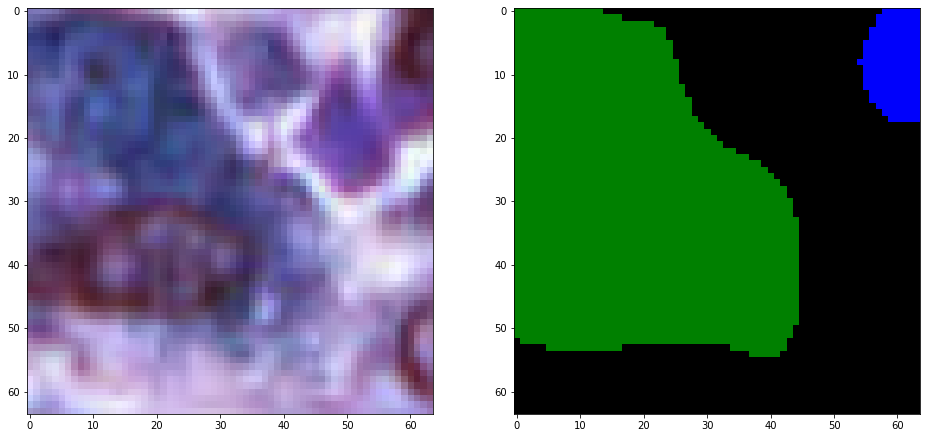

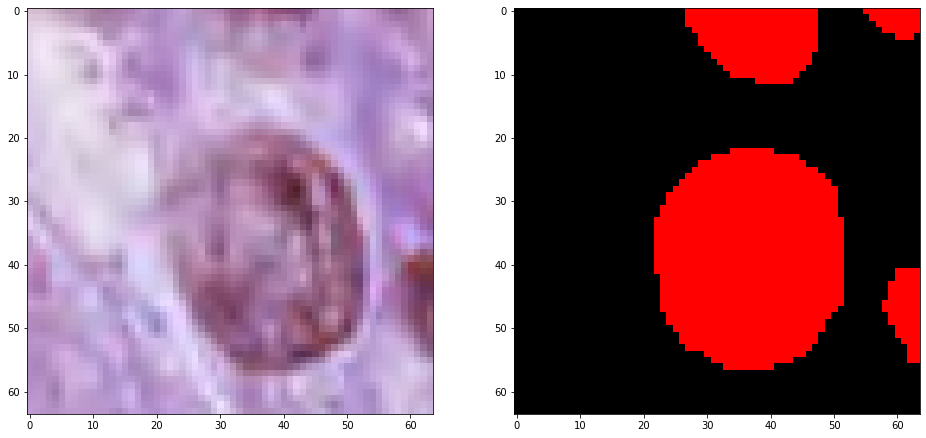

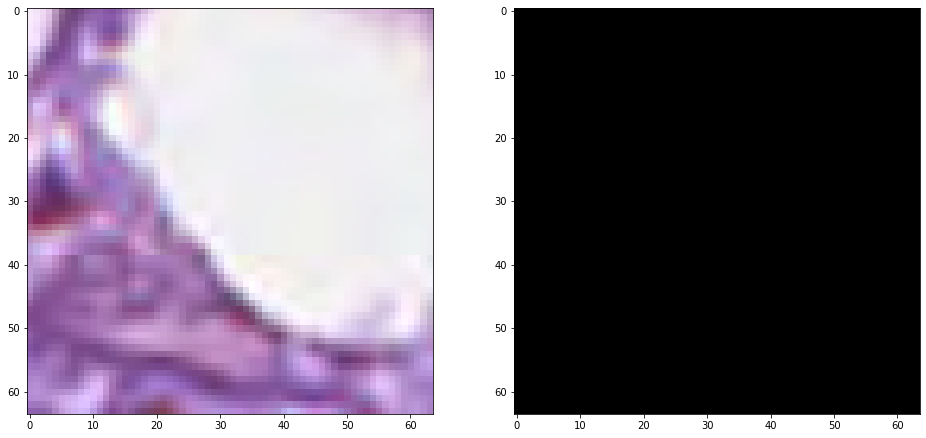

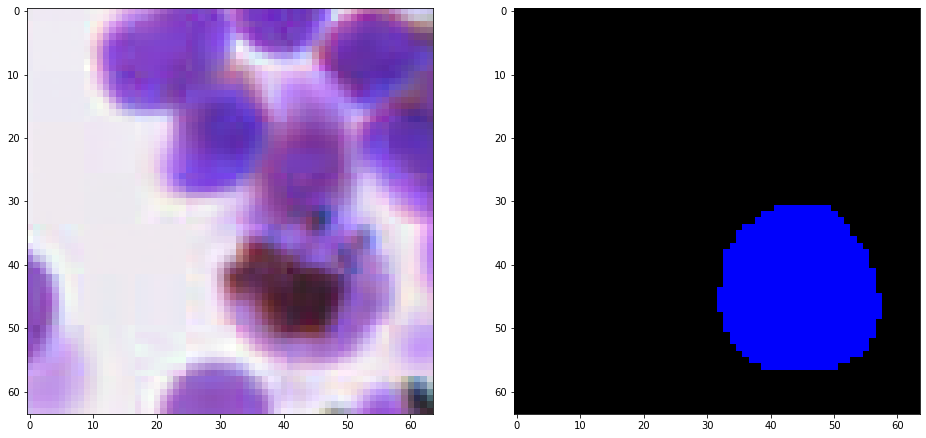

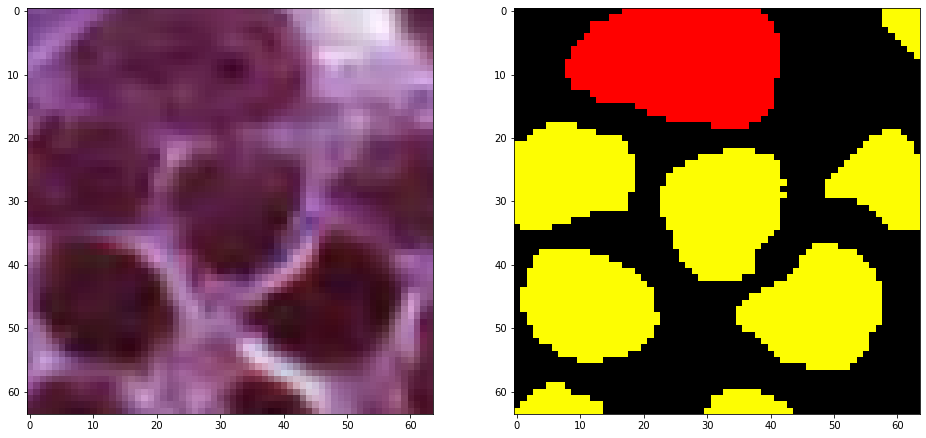

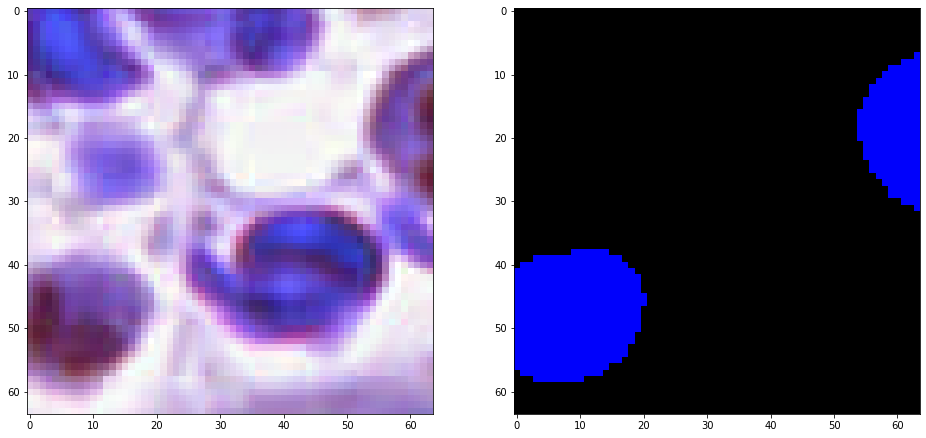

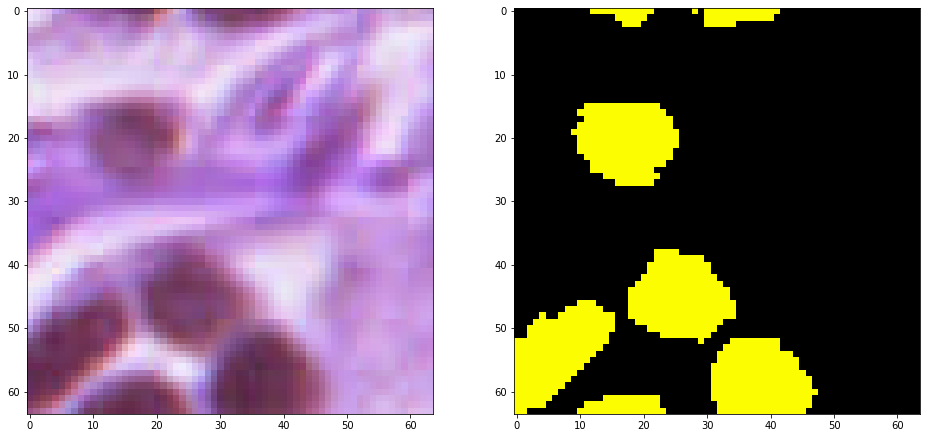

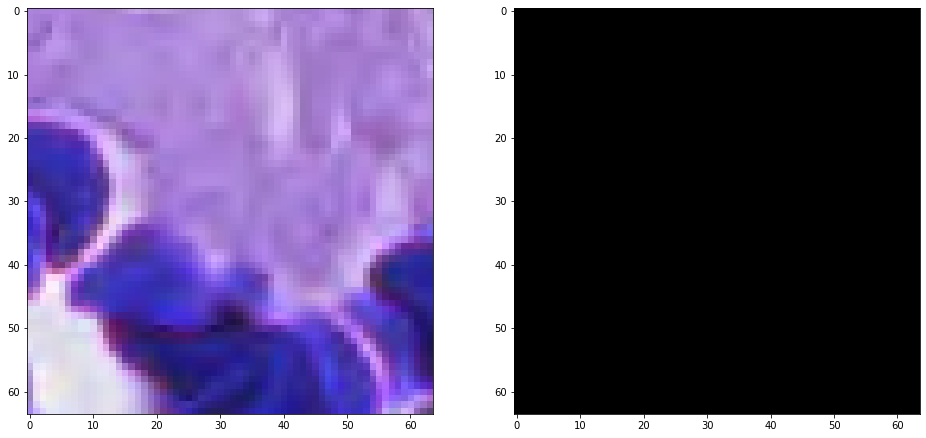

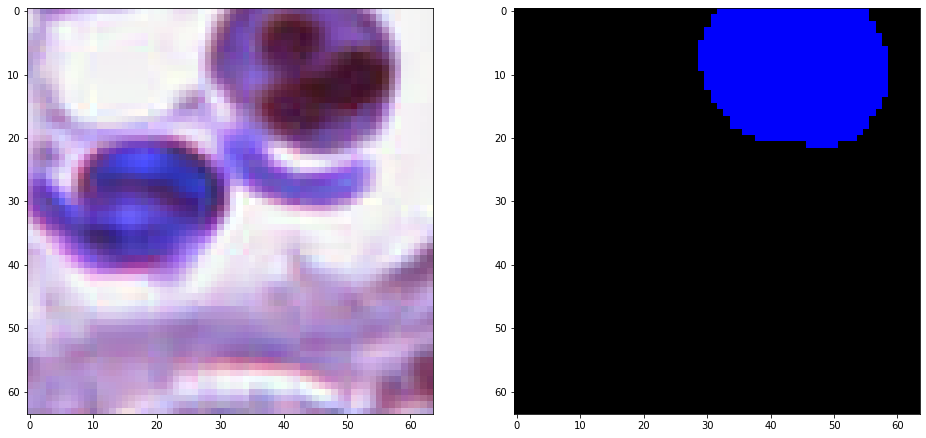

In [13]:
def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

for i in range(50):
    
    idx = random.randrange(len(image_fns))
    print("Index: ", idx)
    
    image = skimage.io.imread(os.path.join(IMAGES_DEST_v1, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST_v1, gt_fns[idx]))
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"

    process(image, gt)